In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [76]:
from keras.preprocessing import image, sequence
from keras.applications import VGG16
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector
from keras.models import Sequential, Model
from keras.optimizers import Nadam

In [3]:
images_dir = os.listdir("caption_generator-master/caption_generator/Flicker8k_Dataset/")

images_path = 'caption_generator-master/caption_generator/Flicker8k_Dataset/'
captions_path = 'caption_generator-master/caption_generator/Flickr8k_text/Flickr8k.token.txt'
train_path = 'caption_generator-master/caption_generator/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = 'caption_generator-master/caption_generator/Flickr8k_text/Flickr_8k.devImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_test = open(val_path, 'r').read().split("\n")

In [4]:
tokens = {}

for ix in range(len(captions)):
    temp = captions[ix].split("#")
    if temp[0] ==  '':
        break
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from skimage.io import imread, imshow

In [7]:
temp = captions[100].split("#")

In [8]:
temp

['1024138940_f1fefbdce1.jpg',
 '0\tTwo different breeds of brown and white dogs play on the beach .']

In [9]:
img = imread(images_path + temp[0])

C:\Workspace\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Workspace\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


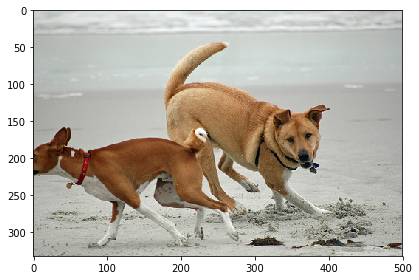

In [10]:
imshow(img)

In [11]:
tokens[temp[0]]

['Two different breeds of brown and white dogs play on the beach .',
 'Two dogs are making a turn on a soft sand beach .',
 'Two dogs playing in the sand at the beach .',
 'Two dogs playing together on a beach .',
 'Two large tan dogs play along a sandy beach .']

In [12]:
print ("Number of Training Images {}".format(len(x_train)))

Number of Training Images 6001


In [13]:
vgg = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

In [14]:
def preprocess_input(img):
    img = img[:, :, :, ::-1] #RGB to BGR
    img[:, :, :, 0] -= 103.939 
    img[:, :, :, 1] -= 116.779
    img[:, :, :, 2] -= 123.68
    return img

In [15]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    return im

In [16]:
x = preprocessing(images_path+temp[0])

In [17]:
x.shape

(1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


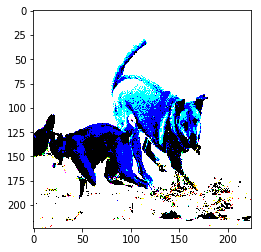

In [18]:
plt.figure(0)
plt.imshow(np.squeeze(x, axis=0))
plt.show()

In [19]:
vgg = Model(inputs=vgg.input, outputs=vgg.layers[-2].output)

In [20]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
def get_encoding(model, img):
    image = preprocessing(images_path+img)
    pred = model.predict(image)
    pred = np.reshape(pred, pred.shape[1])
    return pred

In [22]:
print (temp[0])

print (get_encoding(vgg, temp[0]).shape)

1024138940_f1fefbdce1.jpg
(4096,)


In [38]:
train_dataset = open('caption_generator-master/caption_generator/Flickr8k_text/flickr_8k_train_dataset.txt','w')

In [39]:
train_dataset.write("image_id\tcaptions\n")

18

In [40]:
train_encoded_images = {}

c_train = 0
for img in x_train[:-2]:
    train_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write(img+"\t"+caption+"\n")
        train_dataset.flush()
        c_train += 1
train_dataset.close()

In [42]:
val_dataset = open('caption_generator-master/caption_generator/Flickr8k_text/flickr_8k_val_dataset.txt','w')
val_dataset.write("image_id\tcaptions\n")

18

In [43]:
test_encoded_images = {}

c_test = 0
for img in x_test[:-2]:
    test_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write(img+"\t"+caption+"\n")
        val_dataset.flush()
        c_test += 1
val_dataset.close()

In [44]:
with open( "caption_generator-master/caption_generator/train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_encoded_images, pickle_f )  
    
with open( "caption_generator-master/caption_generator/test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_encoded_images, pickle_f )

In [46]:
pd_dataset = pd.read_csv("caption_generator-master/caption_generator/Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values

In [47]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])

In [48]:
words = [i.split() for i in sentences]

In [49]:
unique = []
for i in words:
    unique.extend(i)

In [50]:
unique = list(set(unique))
print (len(unique))

vocab_size = len(unique)

8252


In [51]:
#Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [52]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

In [53]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

In [55]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print (indices_2_word[padded_sequences[0][ix][iy]],)
    print ("\n")

print (len(padded_sequences[0]))

<start>
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline


<start>
A
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline


<start>
A
black
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline
sideline

In [57]:
with open('caption_generator-master/caption_generator/train_encoded_images.p' , 'rb') as f:
        encoded_images = pickle.load(f)

In [58]:
imgs = []

for ix in range(ds.shape[0]):
    imgs.append(encoded_images[ds[ix, 0]])

imgs = np.asarray(imgs)
print (imgs.shape)

(29995, 4096)


In [59]:
number_of_images = 1500

In [62]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [63]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

for ix in range(number_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("./captions.npy", captions)
np.save("./next_words.npy", next_words)

In [64]:
captions.shape

(19136, 40)

In [65]:
next_words.shape

(19136, 8252)

In [66]:
images = []

for ix in range(number_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("./images.npy", images)

In [67]:
image_names = []

for ix in range(number_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("./image_names.npy", image_names)

In [68]:
len(image_names)

19136

In [69]:
captions = np.load("./captions.npy")
next_words = np.load("./next_words.npy")

In [70]:
images = np.load("./images.npy")

In [72]:
embedding_size = 128

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(4096,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 524,416
Trainable params: 524,416
Non-trainable params: 0
_________________________________________________________________


In [73]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056256   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,392
Trainable params: 1,483,392
Non-trainable params: 0
_________________________________________________________________


In [78]:
from keras.layers import merge
model = Sequential()

model.add(merge([image_model, language_model], mode='concat', concat_axis=-1))
model.add(LSTM(1000, return_sequences=False))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

model.load_weights("./model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])
model.summary()

TypeError: 'module' object is not callable